In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

**Importing the data**

In [2]:
mainData = pd.read_csv("C:\\Users\\ankit\\Desktop\\Python Project\\Sales.csv")

**Summarised information of data**

In [3]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


**We are going to analyse data over Consumer Behaviour - (Profitability VS Repeatability data) so we need only that is :
Quarter, Month, Year, Customername, Country, Sales, DealSize**

**Data Cleaning**

In [4]:
Sales = mainData[['QTR_ID', 'MONTH_ID', 'YEAR_ID', 'CUSTOMERNAME', 'COUNTRY', 'SALES', 'DEALSIZE']]

In [5]:
Sales.head()

,QTR_ID,MONTH_ID,YEAR_ID,CUSTOMERNAME,COUNTRY,SALES,DEALSIZE
0,1,2,2003,Land of Toys Inc.,USA,2871.00,Small
1,2,5,2003,Reims Collectables,France,2765.90,Small
2,3,7,2003,Lyon Souveniers,France,3884.34,Medium
3,3,8,2003,Toys4GrownUps.com,USA,3746.70,Medium
4,4,10,2003,Corporate Gift Ideas Co.,USA,5205.27,Medium


# Functions

**1. Functions defined to filter data**

a. Sales Data of specific year

In [6]:
SalesOfYear = lambda yearID : Sales[Sales["YEAR_ID"]==yearID]

b. Sales Data of specific quarter

In [7]:
SalesOfQtr = lambda Qtr, df : df[df["QTR_ID"]==Qtr]

**2. Functions for framework**

a. Profitability Calculation

In [8]:
def Profit(dataframe) :
    
    avgBill = {}
    
    for item in list(dataframe["CUSTOMERNAME"]) :
        avgBill.update({item : dataframe.loc[dataframe['CUSTOMERNAME']==item, 'SALES'].mean()})
        
    finalprofitdf = pd.DataFrame.from_dict({"Customer" : avgBill.keys(), "Average Deal Size" : avgBill.values()})
    
    return finalprofitdf.sort_values(by="Average Deal Size", ascending=False)

b. Repeatability Calculation

In [9]:
def Repeatability(dataframe) :
    
    Repeat = dataframe["CUSTOMERNAME"].value_counts()
    
    r = {}
    
    for customer in list(dataframe["CUSTOMERNAME"].drop_duplicates()) :
        r.update({customer : Repeat[customer]})
        
    finalrepeatdf = pd.DataFrame.from_dict({"Customer" : list(r.keys()), "Repeatability" : list(r.values())})
    
    return finalrepeatdf

c. Framework - Applying framework on Profitability and Repeatability data to get all the 4 quadrants

In [10]:
def CBFramework(MainData, ProfitabilityData, RepeatabilityData, Quadrant, Sort) :
    
    avgRep=RepeatabilityData["Repeatability"].mean()
    Left=RepeatabilityData[RepeatabilityData["Repeatability"]<=avgRep]
    Right=RepeatabilityData[RepeatabilityData["Repeatability"]>avgRep]
    
    avgProf=MainData["SALES"].mean()
    Lower=ProfitabilityData[ProfitabilityData["Average Deal Size"]<=avgProf]
    Upper=ProfitabilityData[ProfitabilityData["Average Deal Size"]>avgProf]
    
    Premium=pd.merge(Right, Upper, on ="Customer")
    PLow_RHigh=pd.merge(Right, Lower, on = "Customer")
    PHigh_RLow=pd.merge(Left, Upper, on = "Customer")
    Critical=pd.merge(Left, Lower, on = "Customer")
    
    if Quadrant == 'Premium' : finaldf = Premium
    elif Quadrant == 'Profit Low and Repeat High' : finaldf = PLow_RHigh
    elif Quadrant == 'Profit High and Repeat Low' : finaldf = PHigh_RLow
    elif Quadrant == 'Critical' : finaldf = Critical
    else : print("Input Correct Quadrnat Name")
    
    if Sort == 'Average Deal Size' or Sort == 'Repeatability' : 
        return finaldf.sort_values(by=Sort)
    elif Sort == None : 
        return finaldf
    else : 
        return print("Input Correct Sort")

d. Comparison between two framework applied datasets

In [11]:
def Compare(OldData, NewData, DataCategory) :
    
    #Data Sequence : 0_Premium, 1_PLRH, 2_PHRL, 3_Critical
    # Data Category = (Detail, Loss, Maintained or Productive)
    
    Data = []
    Type = []
    Q = ["Premium", "PLowRHigh", "PHighRLow", "Critical"]
    
    for i in range(4) : 
        for j in range(4) :
            Data.append(pd.merge(OldData[i], NewData[j], on="Customer")["Customer"].count())
            Type.append(Q[i]+" to "+Q[j])
            
    Detail = pd.DataFrame({"Type" : Type, "Data" : Data})
    
    Index = {"Loss" : {"Type Of Losses" : ["Loss Of Premium", "PLRH To PHRL", "PHRL To PLRH", "PLRH and PHRL To Critical"], "Loss" : [sum(Detail["Data"][1:4]), Detail["Data"][6], Detail["Data"][9], Detail["Data"][7]+Detail["Data"][11]]},
            "Maintained" : {"Maintainance Type" : ["No Change", "Premium Maintained"], "Maintain" : [Detail["Data"][5]+Detail["Data"][10]+Detail["Data"][15], Detail["Data"][0]]},
            "Productive" : {"Productive Type" : ["Converted To Premium", "Converted To High R", "Converted To High P"], "Productive" : [Detail["Data"][4]+Detail["Data"][8]+Detail["Data"][12], Detail["Data"][13], Detail["Data"][14]]}}
    
    if DataCategory == "Detail" : return Detail
    elif DataCategory == "Loss" or DataCategory == "Maintained" or DataCategory == "Productive" : return pd.DataFrame(Index.get(DataCategory))
    else : return print("Wrong Data Category. Fill (Detail, Loss, Maintained or Productive)")

e. Country Data of framework applied dataset

In [12]:
def CountryData(FrameworkedDataList) :
    #data sequence = [Premium, Profitable, Critical, Loyal]
    
    finalList = []
    
    for q in FrameworkedDataList :
        clist = []
        for customer in list(q["Customer"]) :
            country = list(Sales[Sales["CUSTOMERNAME"]==customer]["COUNTRY"].drop_duplicates())[0]
            clist.append(country)
        finalList.append(Counter(clist))
        
    return finalList

# Framework applied on data of 2003

**Filetering Sales data of 2003**

In [13]:
Sales2003 = SalesOfYear(2003)

In [14]:
Sales2003.head()

,QTR_ID,MONTH_ID,YEAR_ID,CUSTOMERNAME,COUNTRY,SALES,DEALSIZE
0,1,2,2003,Land of Toys Inc.,USA,2871.00,Small
1,2,5,2003,Reims Collectables,France,2765.90,Small
2,3,7,2003,Lyon Souveniers,France,3884.34,Medium
3,3,8,2003,Toys4GrownUps.com,USA,3746.70,Medium
4,4,10,2003,Corporate Gift Ideas Co.,USA,5205.27,Medium


In [119]:
Sales2003.describe()

,QTR_ID,MONTH_ID,YEAR_ID,SALES
count,1000.00000,1000.000000,1000.0,1000.000000
mean,3.10200,8.243000,2003.0,3516.979540
std,1.09398,3.280963,0.0,1763.679136
min,1.00000,1.000000,2003.0,710.200000
25%,2.00000,6.000000,2003.0,2173.935000
50%,4.00000,10.000000,2003.0,3210.095000
75%,4.00000,11.000000,2003.0,4483.447500
max,4.00000,12.000000,2003.0,11279.200000


In [122]:
Sales2003["SALES"].sum()

3516979.54

**Profitability calculation of Sales data of 2003**

In [16]:
Profitability2003 = Profit(Sales2003)

In [17]:
Profitability2003.head()

,Customer,Average Deal Size
41,Super Scale Inc.,5312.345000
10,"Volvo Model Replicas, Co",4874.500000
48,Motor Mint Distributors Inc.,4566.470000
13,Classic Legends Inc.,4551.105455
40,L'ordine Souveniers,4466.974000


In [18]:
Profitability2003.describe()

,Average Deal Size
count,69.000000
mean,3546.461848
std,586.030428
min,1674.230000
25%,3222.970000
50%,3537.402353
75%,3868.295000
max,5312.345000


**Repeatability calculation of Sales data of 2003**

In [19]:
Repeatability2003 = Repeatability(Sales2003)

In [20]:
Repeatability2003.head()

,Customer,Repeatability
0,Land of Toys Inc.,8
1,Reims Collectables,9
2,Lyon Souveniers,7
3,Toys4GrownUps.com,17
4,Corporate Gift Ideas Co.,28


In [21]:
Repeatability2003.describe()

,Repeatability
count,69.000000
mean,14.492754
std,11.004843
min,2.000000
25%,9.000000
50%,12.000000
75%,17.000000
max,60.000000


In [123]:
Repeatability2003["Repeatability"].sum()

1000

**Final Calculated Data - Quadrants Data of 2003**

a. (Q1) Premium Customers of 2003

In [22]:
Premium2003 = CBFramework(Sales2003, Profitability2003, Repeatability2003, 'Premium', 'Average Deal Size')

In [23]:
Premium2003.head()

,Customer,Repeatability,Average Deal Size
5,"Australian Collectors, Co.",17,3537.402353
0,Toys4GrownUps.com,17,3546.388235
10,Cruz & Sons Co.,22,3549.408182
7,"Stylish Desk Decors, Co.",21,3574.504762
3,"Corrida Auto Replicas, Ltd",17,3592.541765


In [24]:
Premium2003.describe()

,Repeatability,Average Deal Size
count,13.000000,13.000000
mean,22.076923,3754.093949
std,7.815173,213.107708
min,15.000000,3537.402353
25%,17.000000,3574.504762
50%,20.000000,3689.954667
75%,25.000000,3924.740667
max,41.000000,4149.320000


b. (Q2) High Profitable Low Repeatable Customers of 2003

In [25]:
ProfitHighRepeatLow2003 = CBFramework(Sales2003, Profitability2003, Repeatability2003, 'Profit High and Repeat Low', 'Average Deal Size')

In [26]:
ProfitHighRepeatLow2003.head()

,Customer,Repeatability,Average Deal Size
17,Souveniers And Things Co.,8,3549.657500
7,Mini Auto Werke,12,3624.061667
20,Auto-Moto Classics Inc.,2,3638.675000
1,Lyon Souveniers,7,3660.697143
11,"Oulu Toy Supplies, Inc.",10,3750.158000


In [27]:
ProfitHighRepeatLow2003.describe()

,Repeatability,Average Deal Size
count,22.000000,22.000000
mean,7.818182,4094.458571
std,3.289758,448.120624
min,2.000000,3549.657500
25%,6.000000,3779.669318
50%,8.500000,3974.285865
75%,10.000000,4397.959306
max,13.000000,5312.345000


c. (Q3) Critical Customers of 2003

In [28]:
Critical2003 = CBFramework(Sales2003, Profitability2003, Repeatability2003, 'Critical', 'Average Deal Size')

In [29]:
Critical2003.head()

,Customer,Repeatability,Average Deal Size
20,Royale Belge,2,1674.230000
19,Boards & Toys Co.,2,2571.075000
17,Signal Gift Stores,13,2603.663077
21,West Coast Collectables Co.,3,2744.853333
5,Salzburg Collectables,14,2759.224286


In [30]:
Critical2003.describe()

,Repeatability,Average Deal Size
count,22.000000,22.000000
mean,9.500000,3094.583763
std,3.912739,433.102189
min,2.000000,1674.230000
25%,8.250000,2861.380806
50%,11.000000,3223.573750
75%,12.000000,3385.848542
max,14.000000,3514.746364


d. (Q4) Loyal - Low Profitable High Repeatable Customers of 2003

In [31]:
ProfitLowRepeatHigh2003 = CBFramework(Sales2003, Profitability2003, Repeatability2003, 'Profit Low and Repeat High', 'Average Deal Size')

In [32]:
ProfitLowRepeatHigh2003.head()

,Customer,Repeatability,Average Deal Size
10,"Australian Collectables, Ltd",16,2367.409375
9,Rovelli Gifts,34,2831.147941
3,Scandinavian Gift Ideas,16,3044.432500
2,Mini Creations Ltd.,32,3060.307188
5,Marseille Mini Autos,17,3087.167059


In [33]:
ProfitLowRepeatHigh2003.describe()

,Repeatability,Average Deal Size
count,12.000000,12.000000
mean,27.666667,3145.309568
std,15.358346,310.688102
min,15.000000,2367.409375
25%,16.000000,3056.338516
50%,22.000000,3201.927000
75%,32.500000,3332.657773
max,60.000000,3503.793000


**Data Visualisation of 2003**

In [34]:
Quadrants2003 = [Premium2003, ProfitHighRepeatLow2003, Critical2003, ProfitLowRepeatHigh2003]

Q2003CustomerCount = []
for item in Quadrants2003 :
    Q2003CustomerCount.append(item["Customer"].count())

a. Quadrant share of 2003 (pie chart)

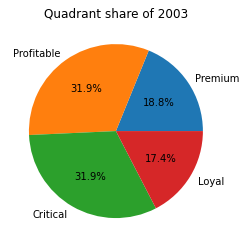

In [35]:
plt.title("Quadrant share of 2003")
plt.pie(np.array(Q2003CustomerCount), labels = ["Premium", "Profitable", "Critical", "Loyal"],autopct='%1.1f%%')
plt.show()

b. Quadrant count of 2003 (bar graph)

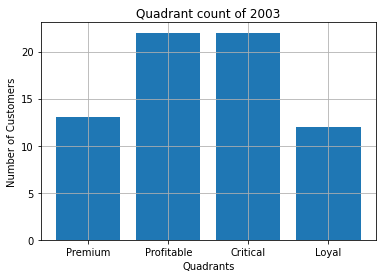

In [36]:
plt.title("Quadrant count of 2003")
plt.ylabel("Number of Customers")
plt.xlabel("Quadrants")
plt.bar(["Premium", "Profitable", "Critical", "Loyal"], Q2003CustomerCount)
plt.grid(True)
plt.show()

c. Country data in different quadrants of 2003

In [37]:
cd2003 = CountryData(Quadrants2003)

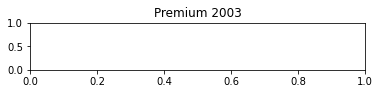

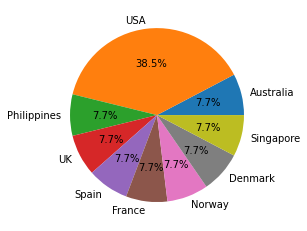

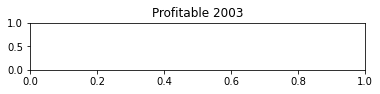

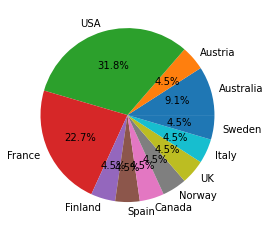

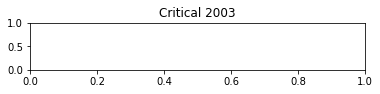

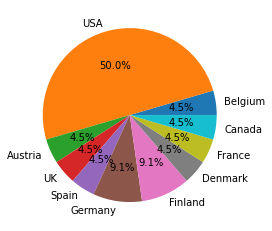

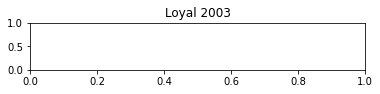

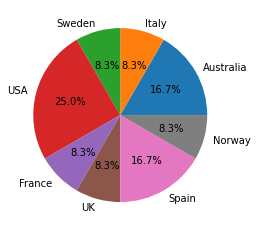

In [38]:
name = ["Premium 2003", "Profitable 2003", "Critical 2003", "Loyal 2003"]
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.title(name[i])
    plt.figure(figsize = (4,4))
    plt.pie(np.array(list(cd2003[i].values())), labels = list(cd2003[i].keys()), autopct='%1.1f%%')
    plt.show()

# Framework applied on data of 2004

**Filtering Sales data of 2004**

In [39]:
Sales2004 = SalesOfYear(2004)

In [126]:
Sales2004.head()

,QTR_ID,MONTH_ID,YEAR_ID,CUSTOMERNAME,COUNTRY,SALES,DEALSIZE
9,1,1,2004,Auto Canal Petit,France,4708.44,Medium
10,1,2,2004,"Australian Collectors, Co.",Australia,3965.66,Medium
11,2,4,2004,Vitachrome Inc.,USA,2333.12,Small
12,2,5,2004,Tekni Collectables Inc.,USA,3188.64,Medium
13,2,6,2004,Gift Depot Inc.,USA,3676.76,Medium


In [124]:
Sales2004["SALES"].sum()

4724162.6

**Profitability calculation of Sales data of 2004**

In [41]:
Profitability2004 = Profit(Sales2004)

In [42]:
Profitability2004.head()

,Customer,Average Deal Size
49,CAF Imports,7665.350000
77,"Australian Collectables, Ltd",6167.410000
50,Suominen Souveniers,5169.705000
57,"Blauer See Auto, Co.",4648.146000
53,"La Corne D'abondance, Co.",4537.405385


In [43]:
Profitability2004.describe()

,Average Deal Size
count,84.000000
mean,3570.464972
std,763.028345
min,1610.440000
25%,3116.272222
50%,3496.055671
75%,3883.480027
max,7665.350000


**Repeatability calculation of Sales data of 2004**

In [44]:
Repeatability2004 = Repeatability(Sales2004)

In [45]:
Repeatability2004.head()

,Customer,Repeatability
0,Auto Canal Petit,24
1,"Australian Collectors, Co.",38
2,Vitachrome Inc.,23
3,Tekni Collectables Inc.,9
4,Gift Depot Inc.,11


In [46]:
Repeatability2004.describe()

,Repeatability
count,84.000000
mean,16.011905
std,14.942858
min,1.000000
25%,8.000000
50%,14.000000
75%,19.250000
max,110.000000


**Final Calculated Data - Quadrants Data of 2004**

a. (Q1) Premium Customers of 2004

In [47]:
Premium2004 = CBFramework(Sales2004, Profitability2004, Repeatability2004, 'Premium', 'Average Deal Size')

In [48]:
Premium2004.head()

,Customer,Repeatability,Average Deal Size
1,Vitachrome Inc.,23,3529.443913
6,Auto Assoc. & Cie.,18,3601.906667
5,Amica Models & Co.,26,3619.894615
0,"Australian Collectors, Co.",38,3706.830789
4,"Tokyo Collectables, Ltd",22,3718.972727


In [49]:
Premium2004.describe()

,Repeatability,Average Deal Size
count,11.000000,11.000000
mean,28.727273,3772.812467
std,14.533347,162.739974
min,17.000000,3529.443913
25%,20.000000,3663.362702
50%,26.000000,3771.680294
75%,30.000000,3850.245338
max,68.000000,4055.494118


b. (Q2) High Profitable Low Repeatable Customers of 2004

In [50]:
ProfitHighRepeatLow2004 = CBFramework(Sales2004, Profitability2004, Repeatability2004, 'Profit High and Repeat Low', 'Average Deal Size')

In [51]:
ProfitHighRepeatLow2004.head()

,Customer,Repeatability,Average Deal Size
22,"Oulu Toy Supplies, Inc.",5,3562.680000
26,Diecast Collectables,2,3564.500000
10,"UK Collectables, Ltd.",14,3600.589286
13,"Clover Collections, Co.",16,3609.776875
23,Lyon Souveniers,9,3624.881111


In [52]:
ProfitHighRepeatLow2004.describe()

,Repeatability,Average Deal Size
count,30.000000,30.000000
mean,9.700000,4198.587915
std,4.764452,840.639145
min,2.000000,3562.680000
25%,5.250000,3787.153500
50%,10.000000,3997.026477
75%,14.000000,4103.802917
max,16.000000,7665.350000


c. (Q3) Critical Customers of 2004

In [53]:
Critical2004 = CBFramework(Sales2004, Profitability2004, Repeatability2004, 'Critical', 'Average Deal Size')

In [54]:
Critical2004.head()

,Customer,Repeatability,Average Deal Size
21,"Iberia Gift Imports, Corp.",2,1610.440000
18,"Bavarian Collectables Imports, Co.",14,2499.565714
1,Atelier graphique,3,2539.886667
17,"Norway Gifts By Mail, Co.",13,2626.574615
4,Quebec Home Shopping Network,9,2729.392222


In [55]:
Critical2004.describe()

,Repeatability,Average Deal Size
count,27.000000,27.000000
mean,9.000000,2972.315838
std,4.690416,374.319398
min,1.000000,1610.440000
25%,5.500000,2851.217143
50%,9.000000,3022.160000
75%,13.500000,3230.345278
max,16.000000,3492.542143


d. (Q4) Loyal - Low Profitable High Repeatable Customers of 2004

In [56]:
ProfitLowRepeatHigh2004 = CBFramework(Sales2004, Profitability2004, Repeatability2004, 'Profit Low and Repeat High', 'Average Deal Size')

In [57]:
ProfitLowRepeatHigh2004.head()

,Customer,Repeatability,Average Deal Size
8,"Royal Canadian Collectables, Ltd.",26,2870.571154
9,giftsbymail.co.uk,26,3009.263077
14,"AV Stores, Co.",35,3051.139714
1,La Rochelle Gifts,25,3068.912400
3,Souveniers And Things Co.,25,3168.091600


In [58]:
ProfitLowRepeatHigh2004.describe()

,Repeatability,Average Deal Size
count,16.000000,16.000000
mean,30.937500,3262.997214
std,22.098171,175.685927
min,17.000000,2870.571154
25%,20.000000,3143.296800
50%,25.000000,3324.472338
75%,31.000000,3378.541875
max,110.000000,3499.569200


**Data Visualisation of 2004**

In [59]:
Quadrants2004 = [Premium2004, ProfitHighRepeatLow2004, Critical2004, ProfitLowRepeatHigh2004]

Q2004CustomerCount = []
for item in Quadrants2004 :
    Q2004CustomerCount.append(item["Customer"].count())

a. Quadrant share of 2003 (pie chart)

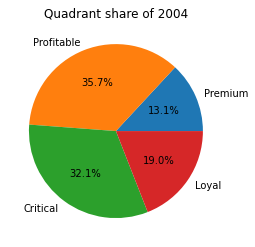

In [60]:
plt.title("Quadrant share of 2004")
plt.pie(np.array(Q2004CustomerCount), labels = ["Premium", "Profitable", "Critical", "Loyal"],autopct='%1.1f%%')
plt.show()

b. Quadrant count of 2003 (bar graph)

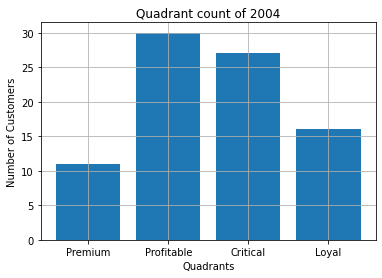

In [61]:
plt.title("Quadrant count of 2004")
plt.ylabel("Number of Customers")
plt.xlabel("Quadrants")
plt.bar(["Premium", "Profitable", "Critical", "Loyal"], Q2004CustomerCount)
plt.grid(True)
plt.show()

c. Country data in different quadrants of 2004

In [62]:
cd2004 = CountryData(Quadrants2004)

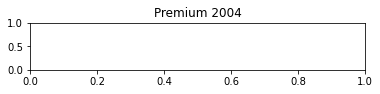

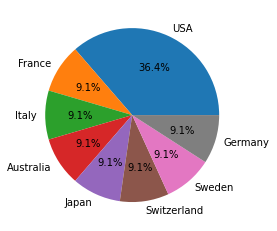

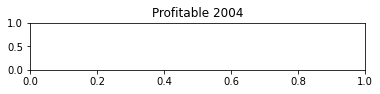

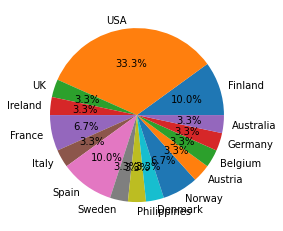

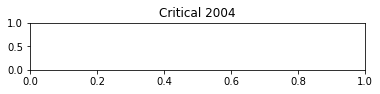

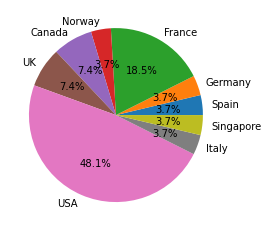

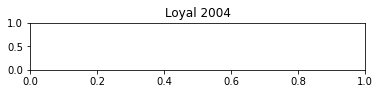

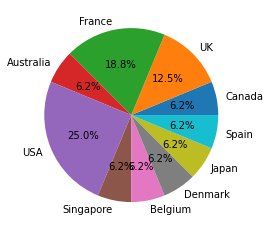

In [63]:
name = ["Premium 2004", "Profitable 2004", "Critical 2004", "Loyal 2004"]
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.title(name[i])
    plt.figure(figsize = (4,4))
    plt.pie(np.array(list(cd2004[i].values())), labels = list(cd2004[i].keys()), autopct='%1.1f%%')
    plt.show()

# Comparison between 2003 and 2004

In [64]:
Data2003 = [Premium2003, ProfitLowRepeatHigh2003, ProfitHighRepeatLow2003, Critical2003]
Data2004 = [Premium2004, ProfitLowRepeatHigh2004, ProfitHighRepeatLow2004, Critical2004]

**Loss - Moving from high quadrant to low quadrant**

In [65]:
YearLoss = Compare(Data2003, Data2004, "Loss")

In [66]:
YearLoss

,Type Of Losses,Loss
0,Loss Of Premium,10
1,PLRH To PHRL,4
2,PHRL To PLRH,3
3,PLRH and PHRL To Critical,12


**Productive - Moving from Low quadrant to High quadrant**

In [67]:
YearProductive = Compare(Data2003, Data2004, "Productive")

In [68]:
YearProductive

,Productive Type,Productive
0,Converted To Premium,4
1,Converted To High R,1
2,Converted To High P,11


**Maintained - Maintained in the respective quadrant**

In [69]:
YearMaintained = Compare(Data2003, Data2004, "Maintained")

In [70]:
YearMaintained

,Maintainance Type,Maintain
0,No Change,15
1,Premium Maintained,1


**Data Visualisation of comparison between 2003 and 2004**

a. Quadrants comparison of 2003 and 2004

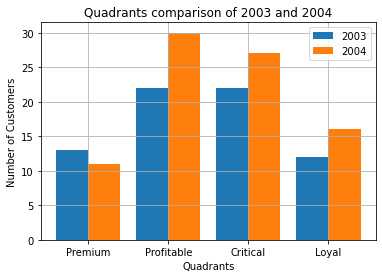

In [71]:
x=np.arange(4)
plt.title("Quadrants comparison of 2003 and 2004")
plt.xlabel("Quadrants")
plt.ylabel("Number of Customers")
width = 0.4
plt.bar(x-0.2, Q2003CustomerCount, width)
plt.bar(x+0.2, Q2004CustomerCount, width)
plt.xticks(x, ["Premium", "Profitable", "Critical", "Loyal"])
plt.legend([2003,2004])
plt.grid(True)
plt.show()

b. The average Sales of 2003 and 2004

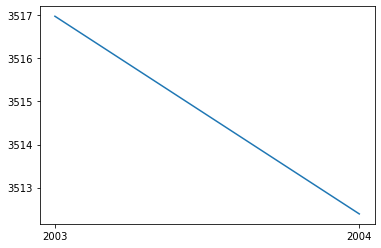

In [72]:
plt.plot(['2003','2004'], [Sales2003["SALES"].mean(), Sales2004["SALES"].mean()])
plt.show()

c. Changes over the quadrants over an year

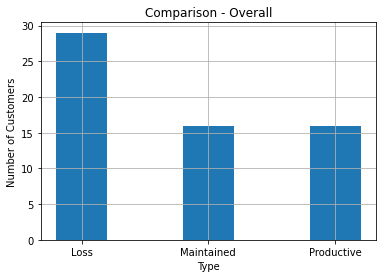

In [73]:
xaxis = ["Loss", "Maintained", "Productive"]
yaxis = [YearLoss["Loss"].sum(), YearMaintained["Maintain"].sum(), YearProductive["Productive"].sum()]
plt.bar(xaxis, yaxis, width=0.4)
plt.title("Comparison - Overall")
plt.xlabel("Type")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()

d. Study of Losses in detail

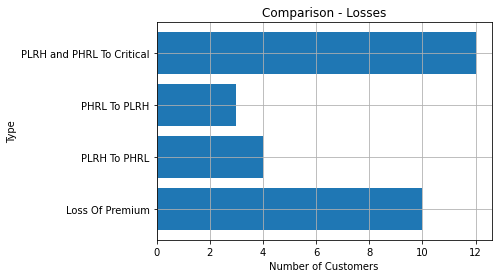

In [74]:
yaxis = list(YearLoss["Type Of Losses"])
xaxis = list(YearLoss["Loss"])
plt.barh(yaxis, xaxis)
plt.title("Comparison - Losses")
plt.ylabel("Type")
plt.xlabel("Number of Customers")
plt.grid(True)
plt.show()

e. Study of maintainace in detail

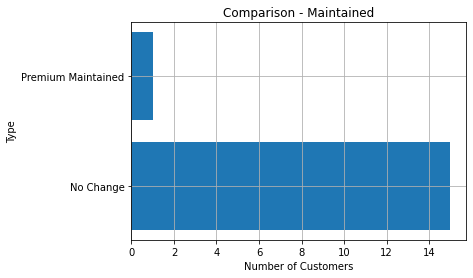

In [75]:
yaxis = list(YearMaintained["Maintainance Type"])
xaxis = list(YearMaintained["Maintain"])
plt.barh(yaxis, xaxis)
plt.title("Comparison - Maintained")
plt.ylabel("Type")
plt.xlabel("Number of Customers")
plt.grid(True)
plt.show()

e. Study of productive detail

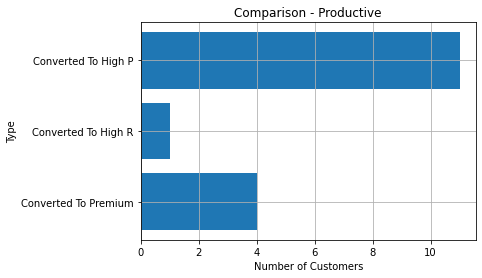

In [76]:
yaxis = list(YearProductive["Productive Type"])
xaxis = list(YearProductive["Productive"])
plt.barh(yaxis, xaxis)
plt.title("Comparison - Productive")
plt.ylabel("Type")
plt.xlabel("Number of Customers")
plt.grid(True)
plt.show()

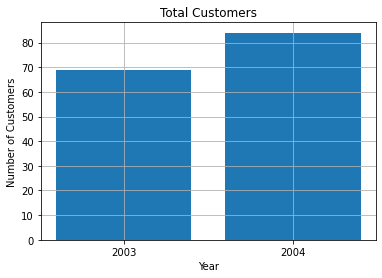

In [77]:
xaxis = ["2003", "2004"]
yaxis = [np.array(Q2003CustomerCount).sum(), np.array(Q2004CustomerCount).sum()]

plt.bar(xaxis, yaxis)
plt.title("Total Customers")
plt.xlabel("Year")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()

**Existing Customers in 2004**

In [78]:
RepeatNextYear=pd.merge(Repeatability2003, Repeatability2004, on="Customer").count()["Customer"]

In [79]:
RepeatNextYear

61

**New Customers in 2004**

In [80]:
NewCustomers = Repeatability2004["Customer"].count()-RepeatNextYear

In [81]:
NewCustomers

23

In [82]:
CustomerNotResponding = Repeatability2003["Customer"].count()-RepeatNextYear

In [83]:
CustomerNotResponding

8

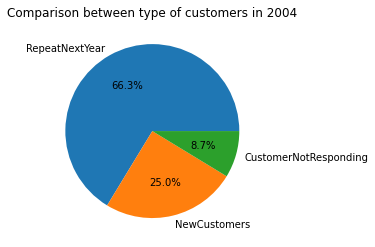

In [84]:
plt.title("Comparison between type of customers in 2004")
plt.pie(np.array([RepeatNextYear, NewCustomers, CustomerNotResponding]), labels = ["RepeatNextYear", "NewCustomers", "CustomerNotResponding"], autopct='%1.1f%%')
plt.show()

# Quarter analysis - 2003

**Quarter's data of 2003**

In [85]:
Qtr_2003 =[]
for i in range(1,5) : Qtr_2003.append(SalesOfQtr(i, Sales2003))
# [[Q1], [Q2], [Q3], [Q4]]

In [86]:
Qtr_2003[0].head()

,QTR_ID,MONTH_ID,YEAR_ID,CUSTOMERNAME,COUNTRY,SALES,DEALSIZE
0,1,2,2003,Land of Toys Inc.,USA,2871.00,Small
26,1,1,2003,Baane Mini Imports,Norway,5404.62,Medium
27,1,3,2003,"Volvo Model Replicas, Co",Sweden,7209.11,Large
54,1,2,2003,Land of Toys Inc.,USA,3896.49,Medium
80,1,2,2003,Land of Toys Inc.,USA,6065.55,Medium


In [87]:
Qtr_2003[0].describe()

,QTR_ID,MONTH_ID,YEAR_ID,SALES
count,130.0,130.000000,130.0,130.000000
mean,1.0,2.084615,2003.0,3423.805308
std,0.0,0.826261,0.0,1538.365534
min,1.0,1.000000,2003.0,710.200000
25%,1.0,1.000000,2003.0,2158.230000
50%,1.0,2.000000,2003.0,3225.970000
75%,1.0,3.000000,2003.0,4304.625000
max,1.0,3.000000,2003.0,8690.360000


**Profitability and Repeatability Data of Quarters of 2003**

In [88]:
PR_Qtr_2003 = []
for qtr in Qtr_2003 : PR_Qtr_2003.append([Profit(qtr), Repeatability(qtr)])
#[[Q1P, Q1R], [Q2P, Q2R], [Q3P, Q3R], [Q4P, Q4R]]

In [89]:
PR_Qtr_2003[0][0].head()

,Customer,Average Deal Size
2,"Volvo Model Replicas, Co",4874.500000
7,Motor Mint Distributors Inc.,4566.470000
3,Danish Wholesale Imports,3924.740667
4,Cruz & Sons Co.,3452.813750
6,Euro Shopping Channel,3432.458462


In [90]:
PR_Qtr_2003[0][0].describe()

,Average Deal Size
count,14.000000
mean,3481.544630
std,586.717685
min,2858.085000
25%,3117.243611
50%,3320.922500
75%,3447.724928
max,4874.500000


**Quadrants Data of Quarters of 2003**

In [91]:
Data_Qtr_2003 = []
d = ['Premium', 'Profit Low and Repeat High', 'Profit High and Repeat Low', 'Critical']
for i in range(4) :
    k = []
    for item in d :
        k.append(CBFramework(Qtr_2003[0], PR_Qtr_2003[i][0], PR_Qtr_2003[i][1], item, 'Average Deal Size'))
    Data_Qtr_2003.append(k)

In [92]:
#[[Q1premium, Q1PLRH, Q3PHRL, Q4Critical], [Q2...], [Q3...], [Q4...]]
Data_Qtr_2003[0][0]
#premium of qtr 1

,Customer,Repeatability,Average Deal Size
2,Euro Shopping Channel,13,3432.458462
1,Cruz & Sons Co.,16,3452.813750
0,Danish Wholesale Imports,15,3924.740667


**Comparison of number of premium customers and other customers of 2003**

In [93]:
Q_2003 = []
for i in range(4) :
    a = []
    for j in range(4) :
        a.append(Data_Qtr_2003[i][j]["Customer"].count())
    Q_2003.append(a)

In [94]:
PremiumCount_2003 = []
for i in range(4) : 
    PremiumCount_2003.append(Q_2003[i][0])

In [95]:
PremiumCount_2003

[3, 5, 5, 11]

In [96]:
OthersCount_2003 = []
for i in range(4) :
    s=0
    for j in range(1,4) :
        s = s + Q_2003[i][j]
    OthersCount_2003.append(s)

In [97]:
OthersCount_2003

[11, 12, 13, 35]

**Visualisation of Quarter analysis of 2003**

a. Quadrant shares of quarters of 2003

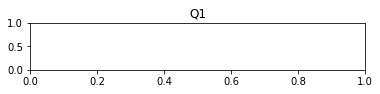

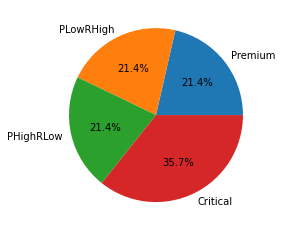

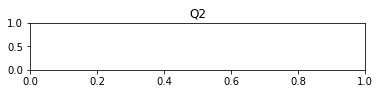

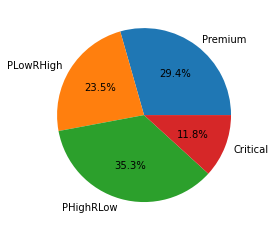

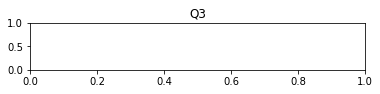

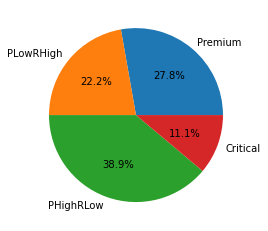

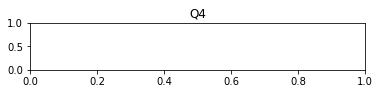

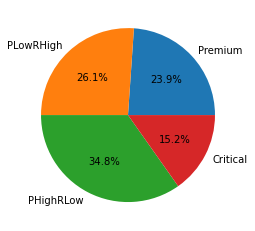

In [98]:
for i in range(4) :
    plt.subplot(4,1,i+1)
    a = []
    for j in range(4) :
        a.append(Data_Qtr_2003[i][j]["Customer"].count())

    plt.title("Q"+str(i+1))
    plt.figure(figsize = (4,4))
    plt.pie(np.array(a), labels = ['Premium', 'PLowRHigh', 'PHighRLow', 'Critical'], autopct='%1.1f%%')
    plt.show()

b. Number of Customers in each of the quadrant of 2003

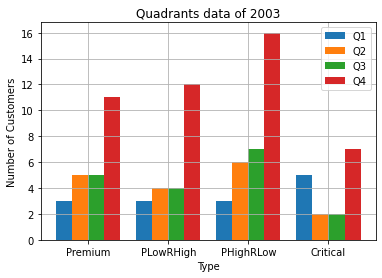

In [99]:
xaxis = ['Premium', 'PLowRHigh', 'PHighRLow', 'Critical']
x=np.array([2,4,6,8])
plt.title("Quadrants data of 2003")    
plt.xlabel("Type")
plt.ylabel("Number of Customers")
width = 0.8
plt.bar(x-0.6, Q_2003[0], width=0.4)
plt.bar(x-0.2, Q_2003[1], width=0.4)
plt.bar(x+0.2, Q_2003[2], width=0.4)
plt.bar(x+0.6, Q_2003[3], width=0.4)
plt.xticks(x, xaxis)
plt.legend(["Q1", "Q2", "Q3", "Q4"])
plt.grid(True)
plt.show()

c. Premium VS Others of 2003

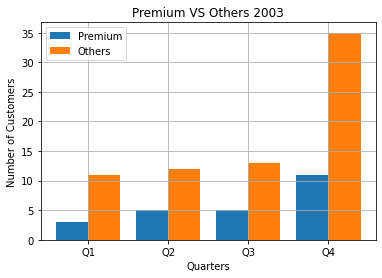

In [100]:
x = np.arange(4)
plt.title("Premium VS Others 2003")
plt.xlabel("Quarters")
plt.ylabel("Number of Customers")
width = 0.4
plt.bar(x-0.2, PremiumCount_2003, width)
plt.bar(x+0.2, OthersCount_2003, width)
plt.xticks(x, ["Q1", "Q2", "Q3", "Q4"])
plt.legend(["Premium", "Others"])
plt.grid(True)
plt.show()

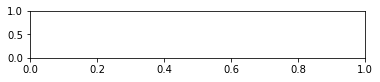

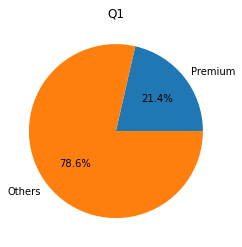

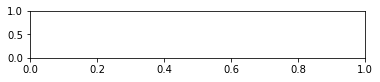

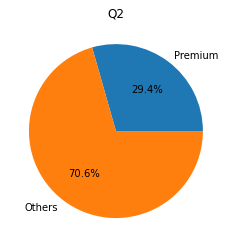

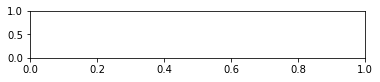

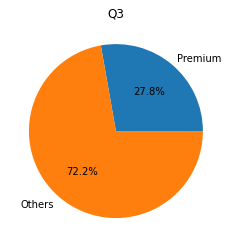

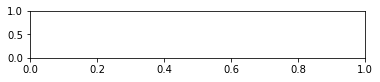

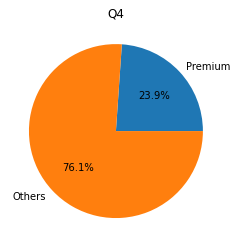

In [101]:
for i in range(4) :
    plt.subplot(4,1,i+1)
    plt.figure(figsize = (4,4))
    plt.title("Q"+str(i+1))
    plt.pie(np.array([PremiumCount_2003[i], OthersCount_2003[i]]), labels = ["Premium", "Others"], autopct='%1.1f%%')
    plt.show()

# Quarter analysis - 2004

**Quarter's data of 2004**

In [102]:
Qtr_2004 =[]
for i in range(1,5) : Qtr_2004.append(SalesOfQtr(i, Sales2004))

In [103]:
Qtr_2004[0].head()

,QTR_ID,MONTH_ID,YEAR_ID,CUSTOMERNAME,COUNTRY,SALES,DEALSIZE
9,1,1,2004,Auto Canal Petit,France,4708.44,Medium
10,1,2,2004,"Australian Collectors, Co.",Australia,3965.66,Medium
36,1,1,2004,West Coast Collectables Co.,USA,6075.30,Medium
37,1,3,2004,Cambridge Collectables Co.,USA,6463.23,Medium
63,1,1,2004,Osaka Souveniers Co.,Japan,3009.09,Medium


In [104]:
Qtr_2004[0].describe()

,QTR_ID,MONTH_ID,YEAR_ID,SALES
count,233.0,233.000000,233.0,233.000000
mean,1.0,1.849785,2004.0,3578.243262
std,0.0,0.781639,0.0,1788.639233
min,1.0,1.000000,2004.0,683.800000
25%,1.0,1.000000,2004.0,2244.900000
50%,1.0,2.000000,2004.0,3184.800000
75%,1.0,2.000000,2004.0,4555.920000
max,1.0,3.000000,2004.0,9774.030000


**Profitability and Repeatability Data of Quarters of 2004**

In [105]:
PR_Qtr_2004 = []
for qtr in Qtr_2004 : PR_Qtr_2004.append([Profit(qtr), Repeatability(qtr)])

In [106]:
PR_Qtr_2004[0][0].head()

,Customer,Average Deal Size
12,CAF Imports,7665.350000
13,Auto Assoc. & Cie.,5759.420000
15,"Blauer See Auto, Co.",4658.311250
11,"Clover Collections, Co.",4309.385556
16,Euro Shopping Channel,4072.823125


In [107]:
PR_Qtr_2004[0][0].describe()

,Average Deal Size
count,23.000000
mean,3817.904864
std,1052.407221
min,2825.740000
25%,3363.178333
50%,3499.569200
75%,3907.314000
max,7665.350000


**Quadrants Data of Quarters of 2004**

In [108]:
Data_Qtr_2004 = []
d = ['Premium', 'Profit Low and Repeat High', 'Profit High and Repeat Low', 'Critical']
for i in range(4) :
    k = []
    for item in d :
        k.append(CBFramework(Qtr_2004[i], PR_Qtr_2004[i][0], PR_Qtr_2004[i][1], item, 'Average Deal Size'))
    Data_Qtr_2004.append(k)

In [109]:
Data_Qtr_2004[0][0]

,Customer,Repeatability,Average Deal Size
0,"Vida Sport, Ltd",14,3602.325000
1,Euro Shopping Channel,16,4072.823125


**Comparison of number of premium customers and other customers**

In [110]:
Q_2004 = []
for i in range(4) :
    a = []
    for j in range(4) :
        a.append(Data_Qtr_2004[i][j]["Customer"].count())
    Q_2004.append(a)

In [111]:
PremiumCount_2004 = []
for i in range(4) : 
    PremiumCount_2004.append(Q_2004[i][0])

In [112]:
PremiumCount_2004

[2, 4, 10, 10]

In [113]:
OthersCount_2004 = []
for i in range(4) :
    s=0
    for j in range(1,4) :
        s = s + Q_2004[i][j]
    OthersCount_2004.append(s)

In [114]:
OthersCount_2004

[21, 19, 20, 36]

**Visualisation of Quarter analysis of 2004**

a. Quadrant shares of quarters of 2004

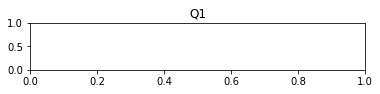

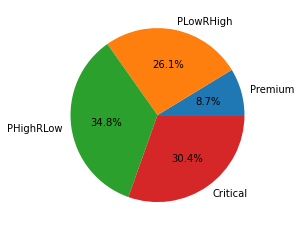

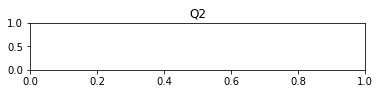

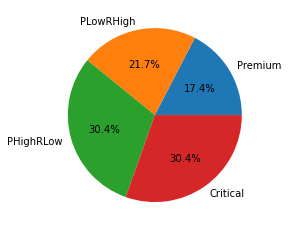

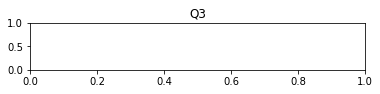

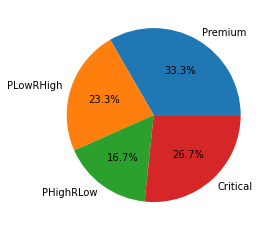

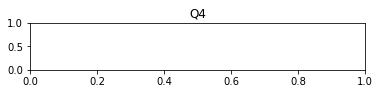

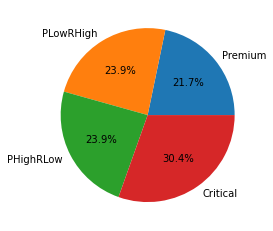

In [115]:
for i in range(4) :
    plt.subplot(4,1,i+1)
    a = []
    for j in range(4) :
        a.append(Data_Qtr_2004[i][j]["Customer"].count())

    plt.title("Q"+str(i+1))
    plt.figure(figsize = (4,4))
    plt.pie(np.array(a), labels = ['Premium', 'PLowRHigh', 'PHighRLow', 'Critical'], autopct='%1.1f%%')
    plt.show()

b. Quadrants b. Number of Customers in each of the quadrant of 2004

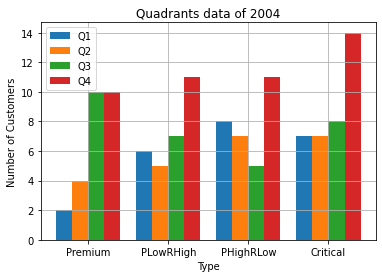

In [116]:
xaxis = ['Premium', 'PLowRHigh', 'PHighRLow', 'Critical']
x=np.array([2,4,6,8])
plt.title("Quadrants data of 2004")    
plt.xlabel("Type")
plt.ylabel("Number of Customers")
width = 0.8
plt.bar(x-0.6, Q_2004[0], width=0.4)
plt.bar(x-0.2, Q_2004[1], width=0.4)
plt.bar(x+0.2, Q_2004[2], width=0.4)
plt.bar(x+0.6, Q_2004[3], width=0.4)
plt.xticks(x, xaxis)
plt.legend(["Q1", "Q2", "Q3", "Q4"])
plt.grid(True)
plt.show()

c. Premium VS Others of 2004

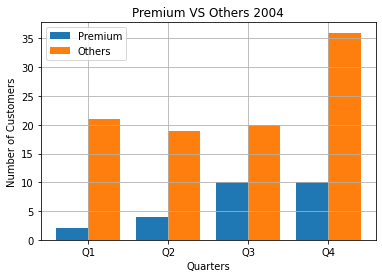

In [117]:
x = np.arange(4)
plt.title("Premium VS Others 2004")
plt.xlabel("Quarters")
plt.ylabel("Number of Customers")
width = 0.4
plt.bar(x-0.2, PremiumCount_2004, width)
plt.bar(x+0.2, OthersCount_2004, width)
plt.xticks(x, ["Q1", "Q2", "Q3", "Q4"])
plt.legend(["Premium", "Others"])
plt.grid(True)
plt.show()

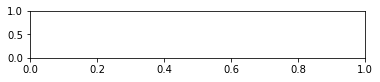

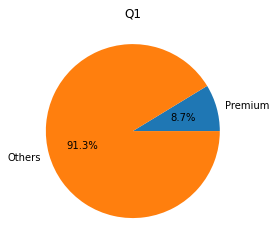

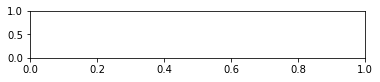

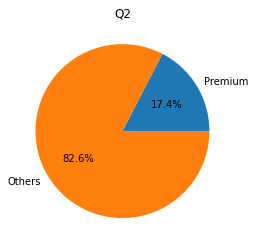

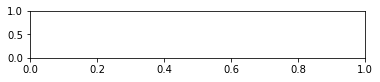

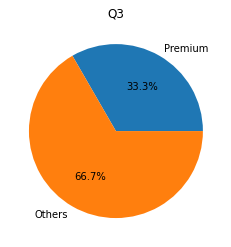

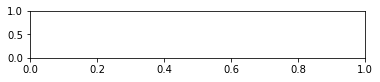

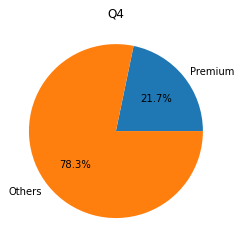

In [118]:
for i in range(4) :
    plt.subplot(4,1,i+1)
    plt.figure(figsize = (4,4))
    plt.title("Q"+str(i+1))
    plt.pie(np.array([PremiumCount_2004[i], OthersCount_2004[i]]), labels = ["Premium", "Others"], autopct='%1.1f%%')
    plt.show()